# Customer Segmentation in Python
## Segmentation using K-Means clustering algorithm
Suppose that we have a company that selling some of the product, and you want to know how well does the selling performance of the product.

You have the data that can we analyze, but what kind of analysis that we can do? 

Well, we can segment customers based on their buying behaviour on the market. 

Keep in mind that the data is really huge, and we can not analyze it using a bare eye. We have to use machine learning algorithms and the power of computing for it.

This article will show you how to cluster customers on segments based on their behaviour using the K-Means algorithm in Python. 

I hope that this article will help you on how to do customer segmentation step-by-step from preparing the data to cluster it.

### Plan Of Attack
Before we get into the process, I will give you a brief on what kind of steps we will get.
- Gather the data
- Pre-process the data
- Explore the data
- Cluster the data
- Interpret the result

### The Analysis

#### Gathering Data

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [2]:
df = pd.read_csv('https://s3.eu-west-1.amazonaws.com/neueda.conygre.com/pydata/ml_fc/customer_info.csv', parse_dates=True, encoding = "ISO-8859-1")

In [3]:
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,01/12/2010 08:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,01/12/2010 08:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,01/12/2010 08:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,01/12/2010 08:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,01/12/2010 08:26,3.39,17850.0,United Kingdom


In [4]:
df = df[df['CustomerID'].notna()]

In [5]:
df_fix = df.sample(10000, random_state = 42)
df_fix.shape

(10000, 8)

In [6]:
df_fix.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
47912,540456,48185,DOORMAT FAIRY CAKE,2,07/01/2011 12:14,7.95,13534.0,United Kingdom
342630,566891,23013,GLASS APOTHECARY BOTTLE TONIC,4,15/09/2011 13:51,3.95,14894.0,United Kingdom
288183,C562139,21313,GLASS HEART T-LIGHT HOLDER,-4,03/08/2011 10:10,0.85,12921.0,United Kingdom
325368,565438,22382,LUNCH BAG SPACEBOY DESIGN,4,04/09/2011 13:56,1.65,17229.0,United Kingdom
331450,566016,21212,PACK OF 72 RETROSPOT CAKE CASES,24,08/09/2011 12:20,0.55,15144.0,United Kingdom


In [9]:
df_fix['InvoiceDate'] = pd.to_datetime(df_fix['InvoiceDate'])
df_fix.dtypes

InvoiceNo              object
StockCode              object
Description            object
Quantity                int64
InvoiceDate    datetime64[ns]
UnitPrice             float64
CustomerID            float64
Country                object
dtype: object

### Data Preprocessing
#### Create RFM Table

In [10]:
# Convert to show date only
from datetime import datetime
df_fix["InvoiceDate"] = df_fix["InvoiceDate"].dt.date

# Create TotalSum colummn
df_fix["TotalSum"] = df_fix["Quantity"] * df_fix["UnitPrice"]

# Create date variable that records recency
import datetime
snapshot_date = max(df_fix.InvoiceDate) + datetime.timedelta(days=1)

# Aggregate data by each customer
customers = df_fix.groupby(['CustomerID']).agg({
    'InvoiceDate': lambda x: (snapshot_date - x.max()).days,
    'InvoiceNo': 'count',
    'TotalSum': 'sum'})

# Rename columns
customers.rename(columns = {'InvoiceDate': 'Recency',
                            'InvoiceNo': 'Frequency',
                            'TotalSum': 'MonetaryValue'}, inplace=True)

In [11]:
customers.head()

,Recency,Frequency,MonetaryValue
CustomerID,,,
12347.0,41,5,133.20
12348.0,221,2,120.88
12349.0,20,2,312.75
12352.0,74,5,80.85
12354.0,234,2,33.30


#### Manage Skewness

C:\Users\frank\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\frank\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\frank\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-lev

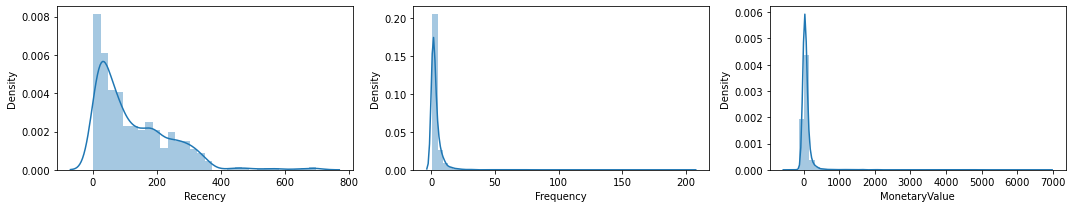

In [13]:
import seaborn as sns
fig, ax = plt.subplots(1, 3, figsize=(15,3))
sns.distplot(customers['Recency'], ax=ax[0])
sns.distplot(customers['Frequency'], ax=ax[1])
sns.distplot(customers['MonetaryValue'], ax=ax[2])
plt.tight_layout()
plt.show()

In [14]:
from scipy import stats
def analyze_skewness(x):
    fig, ax = plt.subplots(2, 2, figsize=(5,5))
    sns.distplot(customers[x], ax=ax[0,0])
    sns.distplot(np.log(customers[x]), ax=ax[0,1])
    sns.distplot(np.sqrt(customers[x]), ax=ax[1,0])
    sns.distplot(stats.boxcox(customers[x])[0], ax=ax[1,1])
    plt.tight_layout()
    plt.show()
    
    print(customers[x].skew().round(2))
    print(np.log(customers[x]).skew().round(2))
    print(np.sqrt(customers[x]).skew().round(2))
    print(pd.Series(stats.boxcox(customers[x])[0]).skew().round(2))

C:\Users\frank\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\frank\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\frank\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-lev

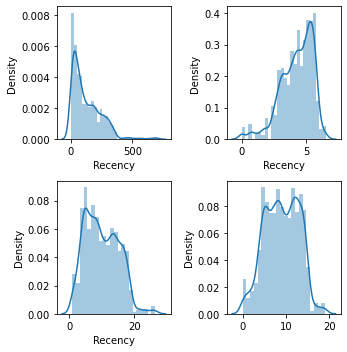

1.44
-0.91
0.38
-0.09


In [16]:
analyze_skewness('Recency')

C:\Users\frank\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\frank\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\frank\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-lev

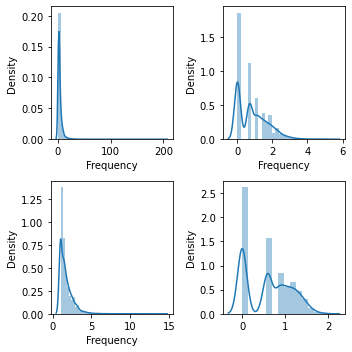

14.77
0.85
3.67
0.16


In [17]:
analyze_skewness('Frequency')

C:\Users\frank\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\frank\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


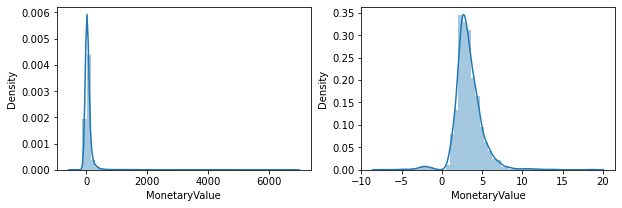

16.63
1.16


In [18]:
fig, ax = plt.subplots(1, 2, figsize=(10,3))
sns.distplot(customers['MonetaryValue'], ax=ax[0])
sns.distplot(np.cbrt(customers['MonetaryValue']), ax=ax[1])
plt.show()
print(customers['MonetaryValue'].skew().round(2))
print(np.cbrt(customers['MonetaryValue']).skew().round(2))

In [19]:
pd.Series(np.cbrt(customers['MonetaryValue'])).values

array([ 5.10702607,  4.94445183,  6.78785317, ..., -1.66910753,
        4.27320639,  4.0872497 ])

In [20]:
# Set the Numbers
customers_fix = pd.DataFrame()
customers_fix["Recency"] = stats.boxcox(customers['Recency'])[0]
customers_fix["Frequency"] = stats.boxcox(customers['Frequency'])[0]
customers_fix["MonetaryValue"] = pd.Series(np.cbrt(customers['MonetaryValue'])).values
customers_fix.tail()

,Recency,Frequency,MonetaryValue
2685,8.410058,0.591193,3.408514
2686,1.697462,1.435599,5.907565
2687,4.595941,0.591193,-1.669108
2688,3.431131,1.615329,4.273206
2689,0.000000,1.017445,4.087250


#### Centering and Scaling Variables

In [22]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(customers_fix)
customers_normalized = scaler.transform(customers_fix)
print(customers_normalized.mean(axis = 0).round(2))
print(customers_normalized.std(axis = 0).round(2))

[-0. -0.  0.]
[1. 1. 1.]


In [23]:
pd.DataFrame(customers_normalized).head()

,0,1,2
0,-0.634954,1.012426,1.017503
1,0.955773,-0.017412,0.925115
2,-1.113785,-0.017412,1.972690
3,-0.161253,1.012426,0.572565
4,1.024177,-0.017412,-0.056441


### Modelling
#### Choose k-number

C:\Users\frank\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1036: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=11.
  warnings.warn(


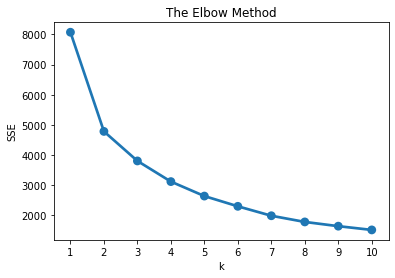

In [25]:
from sklearn.cluster import KMeans

sse = {}
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(customers_normalized)
    sse[k] = kmeans.inertia_ # SSE to closest cluster centroid

plt.title('The Elbow Method')
plt.xlabel('k')
plt.ylabel('SSE')
sns.pointplot(x=list(sse.keys()), y=list(sse.values()))
plt.show()

In [26]:
model = KMeans(n_clusters=3, random_state=42)
model.fit(customers_normalized)
model.labels_.shape

(2690,)

In [27]:
customers.shape

(2690, 3)

### Cluster Analysis

In [28]:
customers["Cluster"] = model.labels_
customers.head()

,Recency,Frequency,MonetaryValue,Cluster
CustomerID,,,,
12347.0,41,5,133.20,1
12348.0,221,2,120.88,2
12349.0,20,2,312.75,1
12352.0,74,5,80.85,1
12354.0,234,2,33.30,2


In [29]:
customers.groupby('Cluster').agg({
    'Recency':'mean',
    'Frequency':'mean',
    'MonetaryValue':['mean', 'count']}).round(1)

Recency Frequency MonetaryValue      
           mean      mean          mean count
Cluster                                      
0          47.5       1.6          20.9   694
1          55.6       7.7         167.7   914
2         237.1       1.7          28.0  1082

### Snake Plots

In [30]:
df_normalized = pd.DataFrame(customers_normalized, columns=['Recency', 'Frequency', 'MonetaryValue'])
df_normalized['ID'] = customers.index
df_normalized['Cluster'] = model.labels_
df_normalized.head()

,Recency,Frequency,MonetaryValue,ID,Cluster
0,-0.634954,1.012426,1.017503,12347.0,1
1,0.955773,-0.017412,0.925115,12348.0,2
2,-1.113785,-0.017412,1.972690,12349.0,1
3,-0.161253,1.012426,0.572565,12352.0,1
4,1.024177,-0.017412,-0.056441,12354.0,2


In [31]:
# Melt The Data
df_nor_melt = pd.melt(df_normalized.reset_index(),
                      id_vars=['ID', 'Cluster'],
                      value_vars=['Recency','Frequency','MonetaryValue'],
                      var_name='Attribute',
                      value_name='Value')
df_nor_melt.head()

,ID,Cluster,Attribute,Value
0,12347.0,1,Recency,-0.634954
1,12348.0,2,Recency,0.955773
2,12349.0,1,Recency,-1.113785
3,12352.0,1,Recency,-0.161253
4,12354.0,2,Recency,1.024177


C:\Users\frank\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='Attribute', ylabel='Value'>

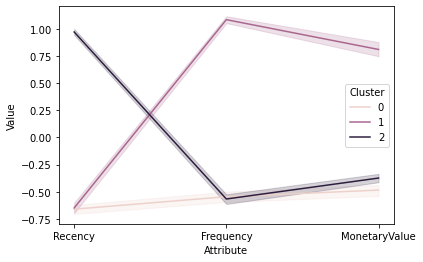

In [32]:
sns.lineplot('Attribute', 'Value', hue='Cluster', data=df_nor_melt)

We infer that cluster 0 is frequent, spend more, and they buy the product recently. Therefore, it could be the cluster of a loyal customer.

Then, the cluster 1 is less frequent, less to spend, but they buy the product recently. Therefore, it could be the cluster of new customer.

Finally, the cluster 2 is less frequent, less to spend, and they buy the product at the old time. Therefore, it could be the cluster of churned customers.

In [33]:
customers.groupby('Cluster').agg({
    'Recency':'mean',
    'Frequency':'mean',
    'MonetaryValue':['mean', 'count']}).round(1)

Recency Frequency MonetaryValue      
           mean      mean          mean count
Cluster                                      
0          47.5       1.6          20.9   694
1          55.6       7.7         167.7   914
2         237.1       1.7          28.0  1082

In [34]:
cluster_avg = customers.groupby('Cluster').mean()
population_avg = customers.mean()
relative_imp = cluster_avg / population_avg - 1
relative_imp

,Cluster,Frequency,MonetaryValue,Recency
Cluster,,,,
0,NaN,-0.566267,-0.716136,-0.624221
1,NaN,1.084014,1.277869,-0.560397
2,NaN,-0.552495,-0.620123,0.873764


### References
Daqing C., Sai L.S, and Kun G., Data mining for the online retail industry: A case study of RFM model-based customer segmentation using data mining (2012), Journal of Database Marketing and Customer Strategy Management.<br>
K. Jarrod Millman and Michael Aivazis. Python for Scientists and Engineers(2011). Computing in Science & Engineering.<br>
https://towardsdatascience.com/top-3-methods-for-handling-skewed-data-1334e0debf45<br>
https://www.geeksforgeeks.org/elbow-method-for-optimal-value-of-k-in-kmeans/<br>
https://github.com/khalidmeister/Customer-Segmentation-using-Python